# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [5]:
# Don’t worry about this. This is needed to interpret the Python code that is embedded in the data set. You only need it literally in the very next code cell and nowhere else. 
from ast import literal_eval

# The rest is just the stuff from the lecture.
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [9]:
rules_data_path = 'rules.tsv.xz'                       # You do not need to decompress this yourself. Pandas understands how to read compressed data.

df_rules = pd.read_csv(rules_data_path,
                       sep='\t',
                       quoting=3,                           # This disables interpretation of quotes by Pandas itself, because both single and double quotes will be resolved by literal_eval.
                       converters={
                           'consequent_item': literal_eval,
                           'antecedent_items': literal_eval # This reads something like ["Grandma's 8\" Chip Cookies", '6" Apple Pie'] into a list, so you will get a column where each individual cell is a list.
                       },
                       low_memory=True)                     # For Chris

But just *how* many rules were just loaded‽

In [12]:
# Show the list of column names and the number of rules.

print(df_rules.columns)
print(len(df_rules))

Index(['consequent_item', 'transaction_count', 'item_set_count',
       'antecedent_count', 'consequent_count', 'antecedent_items'],
      dtype='object')
1048575


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [13]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.

df_rules['support'] = df_rules['item_set_count'] / df_rules['transaction_count']
df_rules['confidence'] = df_rules['item_set_count'] / df_rules['antecedent_count']
df_rules['lift'] = (df_rules['item_set_count'] * df_rules['transaction_count']) / (df_rules['antecedent_count'] * df_rules['consequent_count'])

print(df_rules.head(50))

                                      consequent_item  transaction_count  \
0   Total 2% with Raspberry Pomegranate Lowfat Gre...            3346083   
1   Total 2% Lowfat Greek Strained Yogurt With Blu...            3346083   
2    Total 0% with Honey Nonfat Greek Strained Yogurt            3346083   
3                           Total 0% Raspberry Yogurt            3346083   
4                                 Pineapple Yogurt 2%            3346083   
5                          Fat Free Strawberry Yogurt            3346083   
6                           Fat Free Blueberry Yogurt            3346083   
7   Total 2% with Raspberry Pomegranate Lowfat Gre...            3346083   
8   Total 2% Lowfat Greek Strained Yogurt With Blu...            3346083   
9   Total 2% Greek Strained Yogurt with Cherry 5.3 oz            3346083   
10  Total 2% All Natural Greek Strained Yogurt wit...            3346083   
11                          Total 0% Raspberry Yogurt            3346083   
12          

The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

*(Write your answer here.)*

In [14]:
# Query the rule set if you have to to find out more.

high_support_rules = df_rules[df_rules['support'] > 0.05]
print(high_support_rules)

                consequent_item  transaction_count  item_set_count  \
1033474                  Banana            3346083          491291   
1033475  Bag of Organic Bananas            3346083          394930   
1033476    Organic Strawberries            3346083          275577   
1033477    Organic Baby Spinach            3346083          251705   
1033478    Organic Hass Avocado            3346083          220877   
1033479         Organic Avocado            3346083          184224   

         antecedent_count  consequent_count antecedent_items   support  \
1033474           3346083            491291               []  0.146826   
1033475           3346083            394930               []  0.118028   
1033476           3346083            275577               []  0.082358   
1033477           3346083            251705               []  0.075224   
1033478           3346083            220877               []  0.066011   
1033479           3346083            184224               []  0.0

## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [15]:
# Define df_rules_subset.

df_single_antecedent = df_rules[df_rules['antecedent_items'].apply(len) == 1]

df_lift_filtered = df_single_antecedent[(df_single_antecedent['lift'] >= 5) & (df_single_antecedent['lift'] <= 20)]

df_hummus_filtered = df_lift_filtered[
    df_lift_filtered.apply(
        lambda row: ('Hummus' in row['antecedent_items'][0] or 'Hummus' in row['consequent_item']) and 
                    not ('Hummus' in row['antecedent_items'][0] and 'Hummus' in row['consequent_item']), 
        axis=1
    )
]

df_hummus_filtered['antecedent_item'] = df_hummus_filtered['antecedent_items'].apply(lambda x: x[0])

df_hummus_filtered['antecedent_item'] = df_hummus_filtered['antecedent_item'].apply(lambda x: 'Hummus' if 'Hummus' in x else x)
df_hummus_filtered['consequent_item'] = df_hummus_filtered['consequent_item'].apply(lambda x: 'Hummus' if 'Hummus' in x else x)

df_rules_subset = df_hummus_filtered

print(df_rules_subset)

                                          consequent_item  transaction_count  \
377756  Total 2% Lowfat Greek Strained Yogurt With Blu...            3346083   
387837                                        Clementines            3346083   
416420                                             Hummus            3346083   
419119                                             Hummus            3346083   
422178                                             Hummus            3346083   
440198                                             Hummus            3346083   
442099                               Organic Baby Carrots            3346083   
463035                                             Hummus            3346083   
463988                                             Hummus            3346083   
476420                                             Hummus            3346083   
506520                                             Hummus            3346083   
519416                                  

/tmp/ipykernel_7427/105189016.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hummus_filtered['antecedent_item'] = df_hummus_filtered['antecedent_items'].apply(lambda x: x[0])
/tmp/ipykernel_7427/105189016.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hummus_filtered['antecedent_item'] = df_hummus_filtered['antecedent_item'].apply(lambda x: 'Hummus' if 'Hummus' in x else x)
/tmp/ipykernel_7427/105189016.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

Build a network `graph_rules_subset` from the association rules subset.

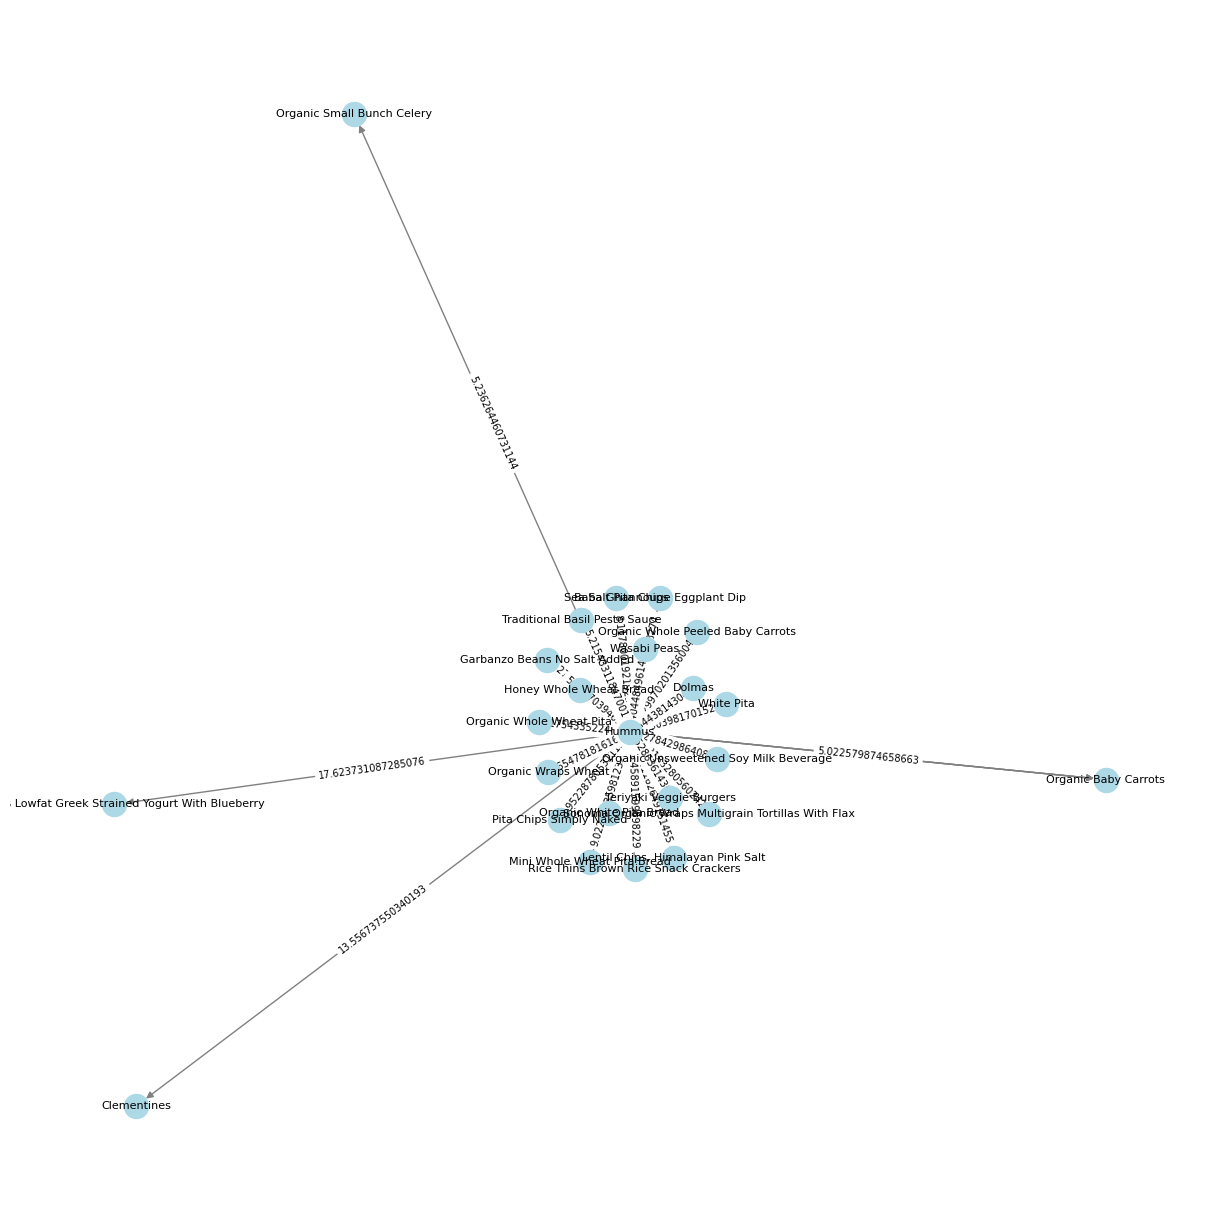

In [16]:
# Define graph_rules_subset (a directed multigraph for handling multiple edges)
graph_rules_subset = nx.MultiDiGraph()

# Add edges from the association rules subset

graph_rules_subset.add_edges_from(
    (row['antecedent_item'], row['consequent_item'], {'lift': row['lift'], 'confidence': row['confidence']})
    for idx, row in df_rules_subset.iterrows()
)

plt.figure(figsize=(12, 12))  

pos = nx.spring_layout(graph_rules_subset)

nx.draw(graph_rules_subset, pos, with_labels=True, node_size=300, font_size=8, 
        node_color="lightblue", font_color="black", edge_color="gray")

edge_labels = nx.get_edge_attributes(graph_rules_subset, 'lift')
nx.draw_networkx_edge_labels(graph_rules_subset, pos, edge_labels=edge_labels, font_size=7)

# Show the plot
plt.show()

What can you tell about people who buy hummus?

*(Write your answer here.)*

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [17]:
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}

df_rules_subset = df_rules[
    (df_rules['antecedent_items'].apply(lambda x: 'Orange Bell Pepper' in x)) | 
    (df_rules['antecedent_items'].apply(lambda x: 'Organic Red Bell Pepper' in x))
]


df_top_20_predictions = df_rules_subset.sort_values('lift', ascending=False).head(20)

print(df_top_20_predictions)

                                          consequent_item  transaction_count  \
342462      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
345882      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
346832           Nonfat Icelandic Style Strawberry Yogurt            3346083   
346901                           Non Fat Raspberry Yogurt            3346083   
349532      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
350852      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
350991                           Non Fat Raspberry Yogurt            3346083   
351360      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
351433           Nonfat Icelandic Style Strawberry Yogurt            3346083   
351881      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
352283                         Vanilla Skyr Nonfat Yogurt            3346083   
352884                        Organic Fr

## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.